In [6]:
import numpy as np
import matplotlib.pyplot as plt

# import lumicks
import lumicks.pylake as lk

# %matplotlib inline
from skimage.transform import rescale
import tifffile
import os
from cv2 import warpAffine, invertAffineTransform
from pathlib import Path
from cv2 import estimateAffine2D, estimateAffinePartial2D
from picasso import io, postprocess
import json
from json import JSONEncoder
import argparse
import itertools
import math
import subprocess


def norm_image(image, inverse=False):
    amin = image.min()
    amax = image.max()
    if inverse:
        return 1 - (image - amin) / (amax - amin)
    else:
        return (image - amin) / (amax - amin)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [7]:
"""
parser = argparse.ArgumentParser(

    description='"Scripts to align various channels based on reference beads."',
    epilog=""" """,
)
parser.add_argument("wt_file", help="WT tif file")
parser.add_argument("irm_file", help="IRM tif file")
parser.add_argument(    "-o",  "--output-directory",    default="output",help="Output directory. Default=output/",)
parser.add_argument("-m", "--transform-matrix", help="Previously calculated matrix in .json format")
parser.add_argument("-f", "--fit_method", default="lq", help="Fit method for picasso.  Default=lq")
parser.add_argument("-b", "--box_size", default=21, help="Box sized for picasso. Default=21")
parser.add_argument("-g","--min_gradient",default=70000,help="Minimum gradient for picasso. Default=70000",)
parser.add_argument("-e","--max_pos_error",default=3.5,help="Maximum standard dev accepted for x and y position of spots. Default=3.5",)
parser.add_argument("-p", "--max_photons", help="Maximum number of photons for spots.")
args = parser.parse_args()
irm_path = args.irm_file
wt_path = args.wt_file
output_path = (args.output_directory + "/")  # The trailing slash is in case it wasn't added by the user
"""

'\nparser = argparse.ArgumentParser(\n\n    description=\'"Scripts to align various channels based on reference beads."\',\n    epilog=,\n)\nparser.add_argument("wt_file", help="WT tif file")\nparser.add_argument("irm_file", help="IRM tif file")\nparser.add_argument(    "-o",  "--output-directory",    default="output",help="Output directory. Default=output/",)\nparser.add_argument("-m", "--transform-matrix", help="Previously calculated matrix in .json format")\nparser.add_argument("-f", "--fit_method", default="lq", help="Fit method for picasso.  Default=lq")\nparser.add_argument("-b", "--box_size", default=21, help="Box sized for picasso. Default=21")\nparser.add_argument("-g","--min_gradient",default=70000,help="Minimum gradient for picasso. Default=70000",)\nparser.add_argument("-e","--max_pos_error",default=3.5,help="Maximum standard dev accepted for x and y position of spots. Default=3.5",)\nparser.add_argument("-p", "--max_photons", help="Maximum number of photons for spots.")\na

In [1]:
# Just to test without arguments


irm_path = "data/13-08-24_calibration_images/20240813-141154_IRM.tif"  # Test images
wt_path = "data/13-08-24_calibration_images/20240813-141154_WT.tif"
bright_path = "data/13-08-24_calibration_images/20240813-141154_Bright-field.tif"

irm_path = "data/vid/20240207-143228_IRM.tif"  # Test images
wt_path = "data/vid/20240207-151245_WT.tif"
bright_path = "data/vid/20240207-151245_Bright-field.tif"


# Reference images

# irm_path = "data/13-08-24_calibration_images/20240813-141353_IRM.tif"
# wt_path = "data/13-08-24_calibration_images/20240813-141353_WT.tif"
# bright_path = "data/13-08-24_calibration_images/20240813-141353_Bright-field.tif"

output_path = "data/vid/output/"
use_existing_matrix = True
align_brightfield = True

bf_transform_matrix_file = "bf_transform_matrix.json"
transform_matrix_file = "transform_matrix.json"
max_photons_exists = False
max_photons = 800000
min_gradient = 30000
box_size = 21
fit_method = "lq"
max_pos_error = 3.5

box_size_bf = 9
min_gradient_bf = 350

In [9]:
# Check if the directory already exists
os.makedirs(output_path, exist_ok=True)

In [10]:
if irm_path.endswith(".tiff"):
    print(f"renaming {irm_path} to .tif")
    os.rename(irm_path, irm_path[:-1])
    irm_path = irm_path[:-1]
if wt_path.endswith(".tiff"):
    print(f"renaming {wt_path} to .tif")
    os.rename(wt_path, wt_path[:-1])
    wt_path = wt_path[:-1]

if bright_path.endswith(".tiff"):
    print(f"renaming {bright_path} to .tif")
    os.rename(bright_path, bright_path[:-1])
    bright_path = bright_path[:-1]

In [11]:
irm = lk.ImageStack(irm_path)  # Loading a stack.
wt = lk.ImageStack(wt_path)  # Loading a stack.

if align_brightfield:
    bright_file = lk.ImageStack(bright_path)
    bright_g = bright_file.get_image(channel="green")
    bright_metadata = bright_file._tiff_image_metadata()

wt.export_tiff(
    output_path + Path(wt_path).stem + "_aligned.tif"
)  # Save aligned wt stack

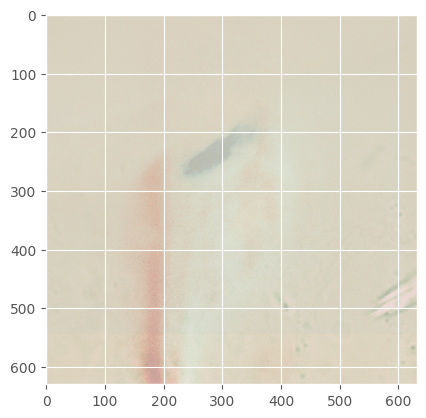

In [12]:
# Get channels
wt_g = wt.get_image(channel="green")

plt.imsave(output_path + Path(wt_path).stem + "_wtG.tiff", wt_g)

# wt_r = wt.get_image(channel='red')  #not really used
# wt_b = wt.get_image(channel='blue') #not really used
irm_g = irm.get_image()
plt.imshow(irm_g, alpha=0.3, cmap="Blues")
plt.imshow(bright_g, alpha=0.3, cmap="Greens")
plt.imshow(wt_g, alpha=0.3, cmap="Reds")

In [13]:
# Get region of interest data

# wt_metadata = wt._tiff_image_metadata()
# wt_roi = wt_metadata["Alignment region of interest (x, y, width, height)"]
# print(wt_roi)

wt_metadata = wt._tiff_image_metadata()
wt_roi = wt_metadata["Region of interest (x, y, width, height)"]
print(wt_roi)

irm_metadata = irm._tiff_image_metadata()
irm_roi = irm_metadata[
    "Region of interest (x, y, width, height)"
]  # This is different because the wt was prexviously aligned I think. Can this cause issues?
print(irm_roi)

bright_roi = bright_metadata[
    "Region of interest (x, y, width, height)"
]  # This is different because the wt was prexviously aligned I think. Can this cause issues?
print(bright_roi)

[669, 21, 632, 630]
[0, 0, 728, 544]
[0, 0, 1280, 1024]


(21.0, 651.0)

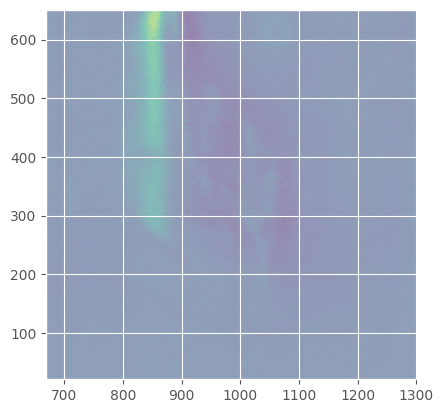

In [14]:
fig, ax1 = plt.subplots()


# Pad both images to region of interest
padded_wt_filename = Path(wt_path).stem + "_padded.tif"
wt_g_padded = np.pad(wt_g, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)])
# wt_g_padded = wt_g
tifffile.imwrite(output_path + padded_wt_filename, wt_g_padded)

padded_irm_filename = Path(irm_path).stem + "_padded.tif"
irm_g_padded = np.pad(irm_g, [(int(irm_roi[1]), 0), (int(irm_roi[0]), 0)])
# irm_g_padded = irm_g
tifffile.imwrite(output_path + padded_irm_filename, irm_g_padded)

if align_brightfield:

    padded_bright_filename = Path(bright_path).stem + "_padded.tif"

    bright_g_padded = np.pad(
        bright_g, [(int(bright_roi[1]), 0), (int(bright_roi[0]), 0)]
    )

    # irm_g_padded = irm_g

    # irm_g_padded = np.pad(irm_g, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])

    # irm_g_padded = np.pad(irm_g_padded, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])

    tifffile.imwrite(output_path + padded_bright_filename, bright_g_padded)


# plt.imshow(bright_g_padded, alpha=0.5)


ax1.imshow(wt_g_padded, alpha=0.5)
ax1.set_xlim(wt_roi[0], wt_roi[0] + wt_roi[2])
ax1.set_ylim(wt_roi[1], wt_roi[1] + wt_roi[3])

# ax1.imshow(irm_g_padded, alpha=0.5)
# ax1.set_xlim(irm_roi[0], irm_roi[0] + irm_roi[2])
# ax1.set_ylim(irm_roi[1], irm_roi[1] + irm_roi[3])


# ax1.imshow(bright_g_padded, alpha=0.5)
# ax1.set_xlim(bright_roi[0], bright_roi[0] + bright_roi[2])
# ax1.set_ylim(bright_roi[1], bright_roi[1] + bright_roi[3])

In [15]:
transform_mat = []  # set to empty to check afterwards if I have a matrix
bf_transform_mat = []
if use_existing_matrix:  # If I have provided a matrix, use that
    with open(transform_matrix_file, "r") as read_file:
        decodedArray = json.load(read_file)
        transform_mat = np.asarray(decodedArray["transform_matrix"])
        print(transform_mat)
        rmsd = decodedArray["rmsd"]
    if align_brightfield:
        with open(bf_transform_matrix_file, "r") as read_file:
            decodedArray = json.load(read_file)
            bf_transform_mat = np.asarray(decodedArray["transform_matrix"])
            print(bf_transform_mat)
            rmsd = decodedArray["rmsd"]
else:  # if matrix wasnt provided, calculate it
    print("Running localize")
    run_string = (
        "python -m picasso localize "
        + output_path
        + padded_wt_filename
        + " --fit-method "
        + fit_method
        + " -b "
        + str(box_size)
        + " --gradient "
        + str(min_gradient)
    )
    subprocess.run(run_string)

    run_string = (
        "python -m picasso localize "
        + output_path
        + padded_irm_filename
        + " --fit-method "
        + fit_method
        + " -b "
        + str(box_size)
        + " --gradient "
        + str(min_gradient)
    )
    subprocess.run(run_string)

    if align_brightfield:
        run_string = (
            "python -m picasso localize "
            + output_path
            + padded_bright_filename
            + " --fit-method "
            + fit_method
            + " -b "
            + str(box_size_bf)
            + " --gradient "
            + str(min_gradient_bf)
        )
    subprocess.run(run_string)
    #!python -m picasso localize {output_path}wt_padded.tif --fit-method $args.fit_method -b  $args.box_size --gradient $args.min_gradient
    #!python -m picasso localize {output_path}irm_padded.tif --fit-method $args.fit_method -b $args.box_size --gradient $args.min_gradient

[[1.05455635e+00 2.95763389e-02 6.95102118e+02]
 [4.19664269e-03 1.05355715e+00 7.49822142e+01]]
[[ 1.24847476e+00  7.76483638e-03  2.37646145e+02]
 [ 1.63616195e-02  1.23488630e+00 -2.79204104e+02]]


In [16]:
# Calculate new Matrix
if not use_existing_matrix:

    # These parameters are for filtering based on position
    irm_min_x = 0  # 370
    irm_min_y = 0  # 392
    irm_max_x = 100000000
    irm_max_y = 100000000

    wt_min_x = 0  # 28
    wt_min_y = 0  # 745
    wt_max_x = 100000000
    wt_max_y = 100000000

    irm_locs_path = output_path + Path(padded_irm_filename).stem + "_locs.hdf5"

    irm_locs, irm_info = io.load_locs(irm_locs_path)

    wt_locs_path = output_path + Path(padded_wt_filename).stem + "_locs.hdf5"

    wt_locs, wt_info = io.load_locs(wt_locs_path)

    wt_locs = wt_locs[wt_locs["sx"] < max_pos_error]

    wt_locs = wt_locs[wt_locs["sy"] < max_pos_error]

    irm_locs = irm_locs[irm_locs["sx"] < max_pos_error]

    irm_locs = irm_locs[irm_locs["sy"] < max_pos_error]

    irm_locs = irm_locs[irm_locs["x"] > irm_min_x]
    irm_locs = irm_locs[irm_locs["y"] > irm_min_y]
    irm_locs = irm_locs[irm_locs["x"] < irm_max_x]
    irm_locs = irm_locs[irm_locs["y"] < irm_max_y]

    wt_locs = wt_locs[wt_locs["x"] > wt_min_x]
    wt_locs = wt_locs[wt_locs["y"] > wt_min_y]
    wt_locs = wt_locs[wt_locs["x"] < wt_max_x]
    wt_locs = wt_locs[wt_locs["y"] < wt_max_y]

    if max_photons_exists:

        wt_locs = wt_locs[wt_locs["photons"] < max_photons]

        irm_locs = irm_locs[irm_locs["photons"] < max_photons]

    wt_locs_xy = wt_locs[["x", "y"]].copy()

    irm_locs_xy = irm_locs[["x", "y"]].copy()

    wt_locs_xy = np.vstack([wt_locs_xy[item] for item in ["x", "y"]]).T.astype(
        np.int64
    )  # Parse to numpy array:

    irm_locs_xy = np.vstack([irm_locs_xy[item] for item in ["x", "y"]]).T.astype(
        np.int64
    )

    ###

    wt_locs_xy = wt_locs_xy[
        np.lexsort((wt_locs_xy[:, 1], wt_locs_xy[:, 0]))
    ]  # Sort the points in case they are in different orders

    irm_locs_xy = irm_locs_xy[np.lexsort((irm_locs_xy[:, 1], irm_locs_xy[:, 0]))]

    ###

    # print(irm_locs_xy)

    # print(wt_locs_xy)

    # plt.scatter(*zip(*wt_locs_xy), s=5)

    # plt.scatter(*zip(*irm_locs_xy), s=5)

    if len(wt_locs_xy) != len(
        irm_locs_xy
    ):  # If number of points is different after filtering give an error an exit
        print(
            "Different number of spots after filtering (wt: "
            + str(len(wt_locs_xy))
            + " vs irm: "
            + str(len(irm_locs_xy))
            + "). Calculation can't continue"
        )

        print("Check your filtering settings")

    else:  # If number of points is the same, calculate affine transform
        print(
            "Number of spots after filtering (wt: "
            + str(len(wt_locs_xy))
            + " vs irm: "
            + str(len(irm_locs_xy))
            + ")."
        )

        affine_transform = estimateAffine2D(irm_locs_xy, wt_locs_xy)

        transform_mat = affine_transform[0]
        print(transform_mat)

        # Manually affine transform the points to output alignment plot

        transform_mat_for_points = np.vstack(
            [transform_mat, (0, 0, 1)]
        )  # have to add this row for affine transform

        warped_irm_locs = []

        for point in irm_locs_xy:

            new_point = (
                point[0],
                point[1],
                1,
            )  # need to add a 1 at the end of the point for affine transform

            # print(new_point)

            transformed_point = np.matmul(
                transform_mat_for_points, new_point
            )  # do the transformation

            new_point = (
                transformed_point[0],
                transformed_point[1],
            )  # transformed point

            warped_irm_locs.append(new_point)

        warped_irm_locs = np.array(warped_irm_locs)

        wt_locs_xy_sorted = wt_locs_xy[
            np.lexsort((wt_locs_xy[:, 1], wt_locs_xy[:, 0]))
        ]  # Sort the points in case they are in different orders

        warped_irm_locs_sorted = warped_irm_locs[
            np.lexsort((warped_irm_locs[:, 1], warped_irm_locs[:, 0]))
        ]

        rmsd = np.sqrt(
            ((((wt_locs_xy_sorted - warped_irm_locs_sorted) ** 2)) * 3).mean()
        )  # calculate RMSD

        numpyData = {
            "transform_matrix": transform_mat,
            "rmsd": rmsd,
        }  # Write transform matrix and rmsd to file

        with open(output_path + "transform_matrix.json", "w") as write_file:

            json.dump(numpyData, write_file, cls=NumpyArrayEncoder)

        # Remove files created during localization

        # os.remove(wt_locs_path)

        # os.remove(irm_locs_path)

        # os.remove(output_path + Path(wt_locs_path).stem + ".yaml")

        # os.remove(output_path + Path(irm_locs_path).stem + ".yaml")

        # Plot aligned points

        # plt.scatter(*zip(*wt_locs_xy), s=5)

        # plt.scatter(*zip(*warped_irm_locs), s=5)

        # plt.savefig(output_path + "aligned_points.png")

        # Now do the same with brightfield

        if align_brightfield:
            # These parameters are for filtering based on position

            bf_min_x = 0  # 28
            bf_min_y = 0  # 745
            bf_max_x = 100000000
            bf_max_y = 100000000

            bf_locs_path = (
                output_path + Path(padded_bright_filename).stem + "_locs.hdf5"
            )
            bf_locs, bf_info = io.load_locs(bf_locs_path)
            bf_locs = bf_locs[bf_locs["sx"] < max_pos_error]
            bf_locs = bf_locs[bf_locs["sy"] < max_pos_error]
            bf_locs = bf_locs[bf_locs["x"] > bf_min_x]
            bf_locs = bf_locs[bf_locs["y"] > bf_min_y]
            bf_locs = bf_locs[bf_locs["x"] < bf_max_x]
            bf_locs = bf_locs[bf_locs["y"] < bf_max_y]

            if max_photons_exists:
                bf_locs = bf_locs[bf_locs["photons"] < max_photons]

            bf_locs_xy = bf_locs[["x", "y"]].copy()

            bf_locs_xy = np.vstack([bf_locs_xy[item] for item in ["x", "y"]]).T.astype(
                np.int64
            )  # Parse to numpy array:

            ###
            bf_locs_xy = bf_locs_xy[
                np.lexsort((bf_locs_xy[:, 1], bf_locs_xy[:, 0]))
            ]  # Sort the points in case they are in different orders

            ###
            # print(irm_locs_xy)
            # print(wt_locs_xy)
            # plt.scatter(*zip(*wt_locs_xy), s=5)
            # plt.scatter(*zip(*irm_locs_xy), s=5)

            if len(wt_locs_xy) != len(
                bf_locs_xy
            ):  # If number of points is different after filtering give an error an exit
                print(
                    "Different number of spots after filtering (wt: "
                    + str(len(wt_locs_xy))
                    + " vs bf: "
                    + str(len(bf_locs_xy))
                    + "). Calculation can't continue"
                )
                print("Check your filtering settings")
            else:
                # If number of points is the same, calculate affine transform
                print(
                    "Number of spots found: (wt: "
                    + str(len(wt_locs_xy))
                    + " vs bf: "
                    + str(len(bf_locs_xy))
                    + ")."
                )
                affine_transform = estimateAffine2D(bf_locs_xy, wt_locs_xy)
                bf_transform_mat = affine_transform[0]
                print(bf_transform_mat)
                # Manually affine transform the points to output alignment plot

                bf_transform_mat_for_points = np.vstack(
                    [bf_transform_mat, (0, 0, 1)]
                )  # have to add this row for affine transform

                warped_bf_locs = []

                for point in bf_locs_xy:
                    new_point = (
                        point[0],
                        point[1],
                        1,
                    )  # need to add a 1 at the end of the point for affine transform
                    # print(new_point)
                    transformed_point = np.matmul(
                        bf_transform_mat_for_points, new_point
                    )  # do the transformation
                    new_point = (
                        transformed_point[0],
                        transformed_point[1],
                    )  # transformed point

                    warped_bf_locs.append(new_point)

                warped_bf_locs = np.array(warped_bf_locs)

                warped_bf_locs_sorted = warped_bf_locs[
                    np.lexsort((warped_bf_locs[:, 1], warped_bf_locs[:, 0]))
                ]
                rmsd = np.sqrt(
                    ((((wt_locs_xy_sorted - warped_bf_locs_sorted) ** 2)) * 3).mean()
                )  # calculate RMSD

                numpyData = {
                    "transform_matrix": bf_transform_mat,
                    "rmsd": rmsd,
                }  # Write transform matrix and rmsd to file
                with open(output_path + "bf_transform_matrix.json", "w") as write_file:
                    json.dump(numpyData, write_file, cls=NumpyArrayEncoder)

                # Remove files created during localization
                # os.remove(wt_locs_path)
                # os.remove(irm_locs_path)
                # os.remove(output_path + Path(wt_locs_path).stem + ".yaml")
                # os.remove(output_path + Path(irm_locs_path).stem + ".yaml")
                # Plot aligned points
                plt.scatter(*zip(*wt_locs_xy), s=9)
                plt.scatter(*zip(*warped_irm_locs), s=9)
                plt.scatter(*zip(*warped_bf_locs), s=9)
                plt.savefig(output_path + "aligned_points.png")
        else:
            plt.scatter(*zip(*wt_locs_xy), s=5)
            plt.scatter(*zip(*warped_irm_locs), s=5)
            plt.savefig(output_path + "aligned_points.png")


else:

    print("Not calculating new matrix. Nothing run")

Not calculating new matrix. Nothing run


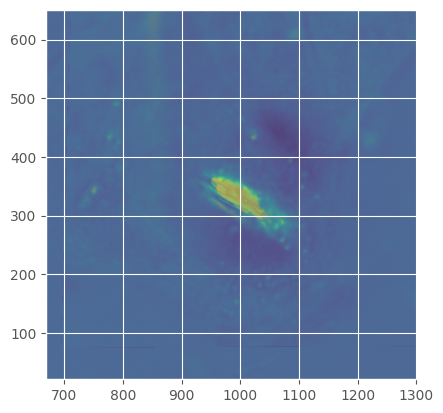

In [17]:
# Align and save
fig, ax1 = plt.subplots()

if len(transform_mat != 0):  # If I have a matrix either from file or calculated

    irm_g_padded_warped = warpAffine(
        irm_g_padded, transform_mat, (wt_g_padded.shape[1], wt_g_padded.shape[0])
    )

    # irm_g_padded_warped = np.pad(irm_g_padded_warped, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)] )

    # This hack is done to reduce the total contrast in the resulting image
    # Otherwise, the 0s make it hard to see
    irm_g_padded_warped[irm_g_padded_warped <= np.amin(irm_g_padded)] = np.mean(
        irm_g_padded
    )

    irm_g_padded_warped = norm_image(irm_g_padded_warped)
    wt_g_padded = norm_image(wt_g_padded)

    # irm_g_padded_warped_cropped = irm_g_padded_warped[#
    #    0 : wt_g_padded.shape[0], 0 : wt_g_padded.shape[1]
    # ]  # crop to size of wt

    tifffile.imwrite(
        output_path + Path(irm_path).stem + "_aligned.tif",
        irm_g_padded_warped,
        metadata=irm_metadata,
    )  # save irm image without the padding

    # plt.imshow(irm_g_padded, alpha=0.5)

    # plt.imshow(irm_g_padded_warped_cropped, alpha=0.5)

    if align_brightfield:  # If a brightfield file was provided align that too

        if len(bf_transform_mat) != 0:

            bright_g_padded_warped = warpAffine(
                bright_g_padded,
                bf_transform_mat,
                (wt_g_padded.shape[1], wt_g_padded.shape[0]),
            )

            # This hack removes the 0s from the affine transform

            # Otherwise, the 0s make it hard to see because of contrast

            bright_g_padded_warped[bright_g_padded_warped <= np.amin(bright_g)] = (
                np.mean(bright_g_padded)
            )

            # normalize

            bright_g_padded_warped = norm_image(bright_g_padded_warped)

            tifffile.imwrite(
                output_path + Path(bright_path).stem + "_aligned.tif",
                bright_g_padded_warped,
                metadata=bright_metadata,
            )  # save irm image without the padding

            stacked_image = np.stack(
                [wt_g_padded, irm_g_padded_warped, bright_g_padded_warped],
                axis=0,
            )  # Save stacked g and irm image
            tifffile.imwrite(
                output_path + Path(wt_path).stem + "_multichannel_aligned.tif",
                np.float32(stacked_image),
                imagej=True,
                metadata={
                    "Composite mode": "composite",  # This is what was needed for fiji to open it merged
                },
            )
            ax1.imshow(wt_g_padded, alpha=0.5)
            ax1.imshow(bright_g_padded_warped, alpha=0.5)
            ax1.imshow(irm_g_padded_warped, alpha=0.5)
            ax1.set_xlim(wt_roi[0], wt_roi[0] + wt_roi[2])
            ax1.set_ylim(wt_roi[1], wt_roi[1] + wt_roi[3])

        else:  # If no bf transform matrix

            print("You also need to provide the brightfield alignment matrix")

    else:

        stacked_image = np.stack(
            [wt_g_padded, irm_g_padded_warped], axis=0
        )  # Save stacked g and irm image
        tifffile.imwrite(
            output_path + Path(wt_path).stem + "_multichannel_aligned.tif",
            np.float32(stacked_image),
            imagej=True,
            metadata={
                "Composite mode": "composite",  # This is what was needed for fiji to open it merged
            },
        )
        # plt.imshow(bright_g_padded_warped, alpha=0.5)

        ax1.imshow(wt_g_padded, alpha=0.5)

        ax1.imshow(irm_g_padded_warped, alpha=0.5)
        ax1.set_xlim(wt_roi[0], wt_roi[0] + wt_roi[2])
        ax1.set_ylim(wt_roi[1], wt_roi[1] + wt_roi[3])

    # plt.imshow(wt_g)

    # delete padded files

    # os.remove(output_path + padded_irm_filename)

    # os.remove(output_path + padded_wt_filename)

In [18]:
irm._src.close()  # need to close the file before deleting
wt._src.close()  # need to close the file before deleting
bright_file._src.close()